# GAUSSIAN DISTRIBUTION AND ANAMOLY DETECTION

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
%matplotlib inline

In [2]:
import scipy as sy
from scipy.io import loadmat
from scipy.stats import multivariate_normal
import math

## 1. Gaussian Distribution

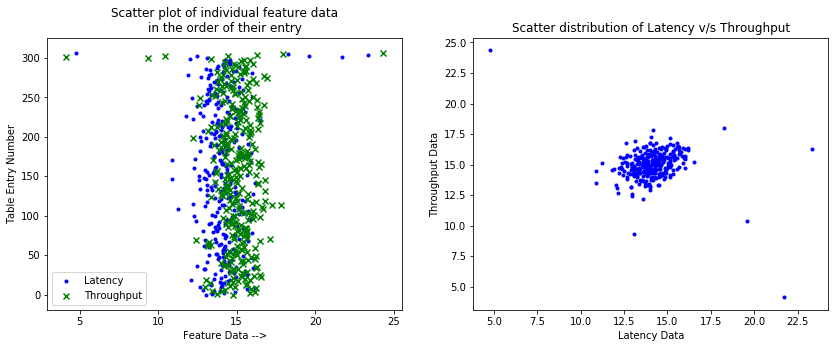

The size of data matrix (X) is (307, 2). The data is not mean centered.


In [3]:
data1 = loadmat('ex8data1.mat')
X = data1['X']

fig, ax = plt.subplots(1,2,figsize=(14,5))
ax[0].scatter(X[:,0], np.array(list(range(len(X)))), color = 'blue', marker='.', label='Latency')
ax[0].scatter(X[:,1], np.array(list(range(len(X)))), color = 'green', marker='x', label= 'Throughput')
ax[0].set_title('Scatter plot of individual feature data\nin the order of their entry')
ax[0].set_xlabel('Feature Data -->')
ax[0].set_ylabel('Table Entry Number')
ax[0].legend()

ax[1].scatter(X[:,0], X[:,1], color='blue', marker='.')
ax[1].set_title('Scatter distribution of Latency v/s Throughput')
ax[1].set_xlabel('Latency Data')
ax[1].set_ylabel('Throughput Data')

plt.show()

print(f'The size of data matrix (X) is {X.shape}. The data is not mean centered.')

### Function Definitions

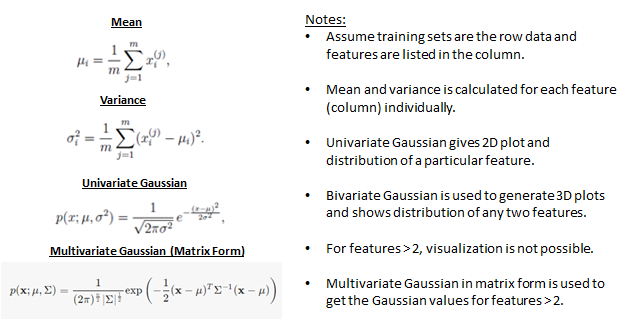

In [4]:
from IPython.display import Image
Image(filename = "D:\Python_Work\Machine_Learning\Coursera\Exercises\Recommender_Systems\Gaussian.png")

In [5]:
def mu_sigma(X):
    m,n = X.shape
    mu = np.mean(X, axis=0)    # or mu = (1/m) * sum(X)
    sigma = (1/m) * sum((X-mu)**2)
    sigma = np.diag(sigma) # --> Critical Step: Shapes the variances into a square matrix with shape = no. of features
    return mu, sigma

def uni_Gaussian(X):
    mu, sigma = mu_sigma(X)
    constant_term = 1/(2*math.pi*sigma)**(1/2)
    exp_term = -((X - mu)**2)/(2*sigma)
    G = constant_term * np.exp(exp_term)
    X_dist = np.append(X-mu, G, axis=1)
    X_sort = X_dist[X_dist[:,0].argsort()]
    return X_sort

def multiGauss(X, mu, sigma): 
    k = len(sigma)
    det_sigma = np.linalg.det(sigma)
    inv_sigma = np.linalg.inv(sigma)
    frac_term = 1/(((2 * math.pi)**(k/2)) * (det_sigma**0.5))
    
    if X.ndim > 2: # --> Complex Matrix Calculation for 3D plot only (see description)
        exp_term = -0.5 * np.einsum('...k,kl,...l->...', X, inv_sigma, X)
        G = frac_term * np.exp(exp_term)
    else:
        exp_term = -0.5 * np.sum(X.dot(inv_sigma) * (X), axis=1) 
        G = frac_term * np.exp(exp_term)
    
    return G


### Univariate Gaussian Visualisation

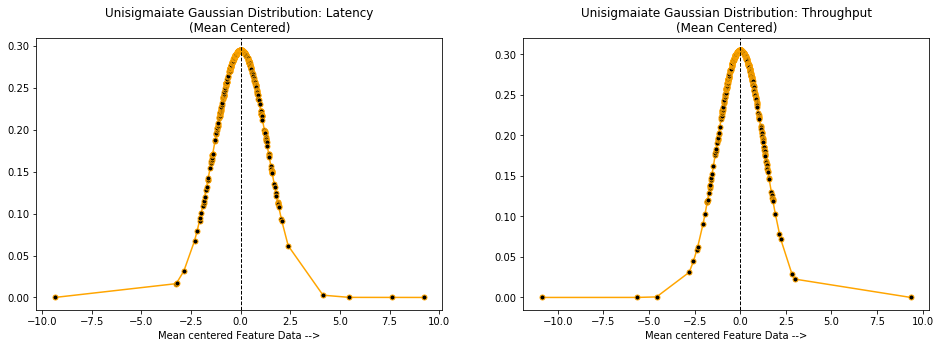

In [6]:
x1 = X[:,0].reshape(-1,1)
G_x1 = uni_Gaussian(x1)

x2 = X[:,1].reshape(-1,1)
G_x2 = uni_Gaussian(x2)

GX = [G_x1, G_x2]
feat = ['Latency','Throughput']

fig, ax = plt.subplots(1,2,figsize=(16,5))
for i in range(len(GX)):
    ax[i].plot(GX[i][:,0], GX[i][:,1], marker = '.', color='orange', ms=10, mfc='black', label = feat[i])
    ax[i].set_xlabel('Mean centered Feature Data -->')
    ax[i].set_title(f'Unisigmaiate Gaussian Distribution: {feat[i]}\n(Mean Centered)')
    ax[i].axvline(0, linestyle='--', color='black', linewidth=1)
plt.show()


### Bivariate Gaussian Visualisation using Python MeshGrid plot

In [7]:
def meshgrid(X, col_idx1 = 0, col_idx2 = 1, shape='3D', mean_center = 1):
    idx = [col_idx1, col_idx2]
    dt_x = []
    max_val = []
    min_val = []
    for i in range(2):
        dt_x.append((max(X[:,idx[i]])-min(X[:,idx[i]]))/10)
        max_val.append(max(X[:,idx[i]]) + dt_x[i])
        min_val.append(min(X[:,idx[i]]) - dt_x[i])
     
    xm = np.linspace(min_val[0], max_val[0], 50)
    ym = np.linspace(min_val[1], max_val[1], 50)
    
    
    # Note: Meshgrid has to be mean centered if sigma (original data) is already mean centered.
    if mean_center == 1:
        mu_1 = np.mean(xm, axis=0)
        mu_2 = np.mean(ym, axis=0)
        xx, yy = np.meshgrid(xm-mu_1, ym-mu_2)
    else:
        mu_1 = 0
        mu_2 = 0
        xx, yy = np.meshgrid(xm-mu_1, ym-mu_2)
    
    # Creating the 3D Matrix for Surface Generation
    if shape == '3D':
        pos = np.empty(xx.shape + (2,))
        pos[:,:,0] = xx
        pos[:,:,1] = yy
    else:
        pos = np.array([xx.flatten(), yy.flatten()]).T

    return xx, yy, pos

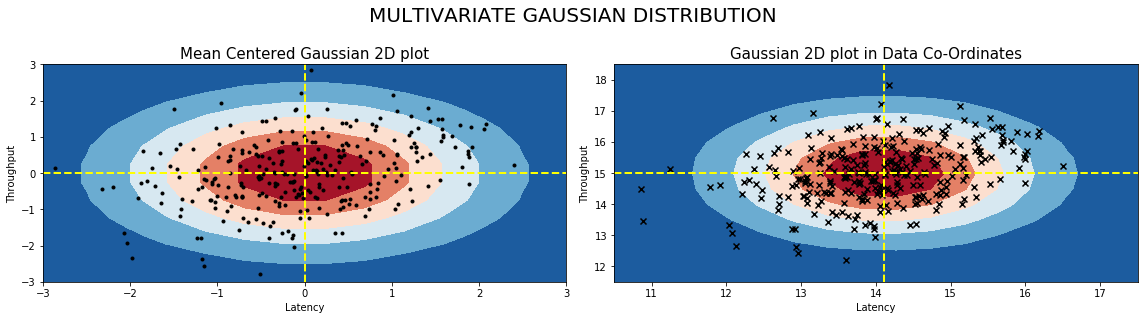

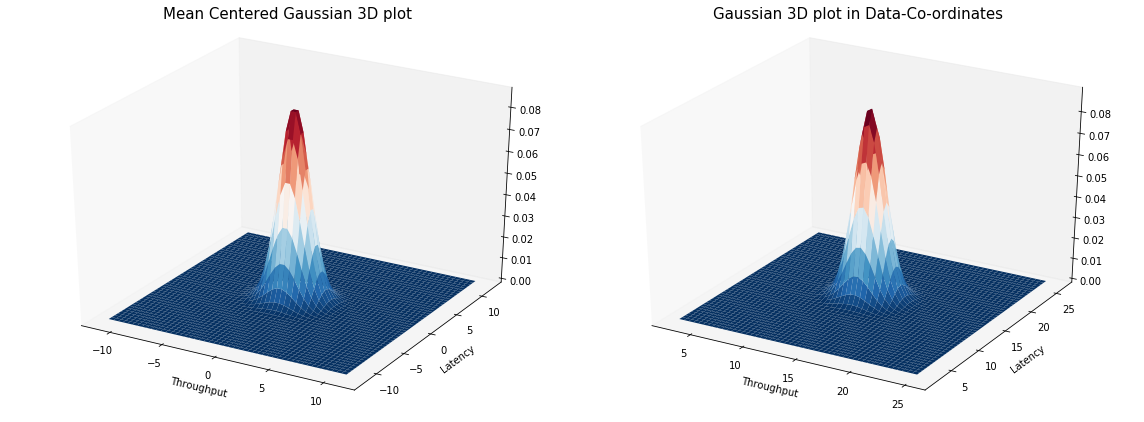

In [9]:
## Training Set Gaussian
mu, sigma = mu_sigma(X)
Gtrain = multiGauss(X-mu, mu, sigma)

##############################################################################

xx1, yy1, pos1 = meshgrid(X,0,1, shape='2D', mean_center = 1)
zz1 = multiGauss(pos1, mu, sigma)

fig, ax = plt.subplots(1,2,figsize=(16,4))

ax[0].scatter((X - mu)[:,0], (X - mu)[:,1], color='black', marker='.')
ax[0].contourf(xx1,yy1,zz1.reshape(50,50), cmap='RdBu_r', zorder=0)
ax[0].set_xlim(-3,3)
ax[0].set_ylim(-3,3)
ax[0].set_title('Mean Centered Gaussian 2D plot', size=15)
ax[0].set_xlabel('Latency')
ax[0].set_ylabel('Throughput')
ax[0].axvline(0, linestyle='--', color='yellow', linewidth=2)
ax[0].axhline(0, linestyle='--', color='yellow', linewidth=2)

#######################################
xx3, yy3, pos3 = meshgrid(X,0,1, shape='2D', mean_center = 0)
zz3 = multiGauss(pos3-mu, mu, sigma)
ax[1].scatter(X[:,0], X[:,1], color='black', marker='x')
ax[1].contourf(xx3,yy3,zz3.reshape(50,50), cmap='RdBu_r', zorder=0)
ax[1].set_xlim(10.5,17.5)
ax[1].set_ylim(11.5,18.5)
ax[1].set_title('Gaussian 2D plot in Data Co-Ordinates', size=15)
ax[1].set_xlabel('Latency')
ax[1].set_ylabel('Throughput')
ax[1].axvline(mu[0], linestyle='--', color='yellow', linewidth=2)
ax[1].axhline(mu[1], linestyle='--', color='yellow', linewidth=2)

fig.suptitle('MULTIVARIATE GAUSSIAN DISTRIBUTION', x=0.5,y=1.1, size=20)
fig.tight_layout()
plt.show()
################################################################################################
################################################################################################
xx2, yy2, pos2 = meshgrid(X,0,1, shape='3D', mean_center = 1)
zz2 = multiGauss(pos2, mu, sigma)

fig2 = plt.figure(figsize=(16,6))
ax2 = fig2.add_subplot(1,2,1,projection='3d')
ax3 = fig2.add_subplot(1,2,2,projection='3d')

ax2.plot_surface(xx2, yy2, zz2, cmap='RdBu_r',linewidth=0)

ax2.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax2.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax2.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)

ax2.set_title('Mean Centered Gaussian 3D plot', position=(0.5,1.05), size=15)
ax2.set_xlabel('Throughput')
ax2.set_ylabel('Latency')

##########################################
xx4, yy4, pos4 = meshgrid(X,0,1, shape='3D', mean_center = 0)
zz4 = multiGauss(pos4-mu, mu, sigma)

ax3.plot_surface(xx4, yy4, zz4, cmap='RdBu_r',linewidth=0)

ax3.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax3.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax3.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)

ax3.set_title('Gaussian 3D plot in Data-Co-ordinates', position=(0.5,1.05), size=15)
ax3.set_xlabel('Throughput')
ax3.set_ylabel('Latency')

fig2.tight_layout()
plt.show()

## 2. Anamoly Detection

### Concept Definition

<blockquote>The Gaussian function is also called a Probability Density function (PDF), p(x).<br>
   • To flag an anamoly, a threshold called $\epsilon$ is established. This threshold is nothing but a selected value of PDF.<br>
    • The criteria is that if p(x)  $< \epsilon$, then the particular training set associated with the PDF is treated as an anamoly.<br> 
    • The value of $\epsilon$ is obtained by iterating using classification parameters such as precision, recall and F1 score.<br><br>
    <b>If p(x) $< \epsilon$, the PDF is flagged as an anamoly (y=1).</b><br><br>
        This value of y is compared with classification results available in the validation sets and the resulting values of True Positives (tp), False Positives (fp) and False Negative (fn) are used to calculate the F1 score.<br>
    <emsp>1. True Positive (tp) : $y_{pdf}$ = 1 <ensp>and $y_{validation}$ = 1 <br>
        <emsp>2. False Positive (fp) : $y_{pdf}$ = 1 <ensp>and $y_{validation}$ = 0 <br>
            <emsp>3. False Negative (fn) : $y_{pdf}$ = 0 <ensp>and $y_{validation}$ = 1 <br><br>
    <b>Iteration of $\epsilon$ optimises the F1 score and establishes the threshold PDF.</b>
    

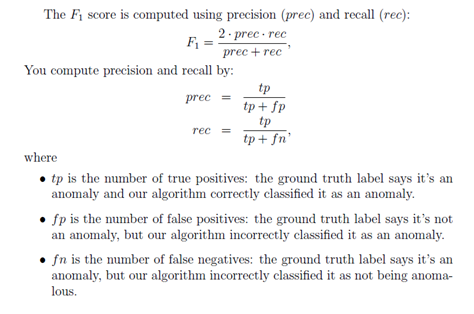

In [10]:
from IPython.display import Image
Image(filename = "D:\Python_Work\Machine_Learning\Coursera\Exercises\Recommender_Systems\F1.png")

In [11]:
def anamoly(X, mu, sigma, y_classified):
    
    G = multiGauss(X-mu, mu, sigma)
    
    num_iter = 1000
    step = (max(G) - min(G))/num_iter
    opt_F1 = 0
    opt_eps = 0
    
    eps = 0 
    for i in range(num_iter):
        pred = np.zeros([G.shape[0],1])
        for j in range(len(G)):
            if G[j] < eps:
                pred[j] = 1
        
        tp, fp, fn = 0, 0, 0
        for j in range(len(pred)):
            if pred[j] == 1 and y_classified[j] == 1:
                tp += 1
            elif pred[j] == 1 and y_classified[j] == 0:
                fp += 1
            elif pred[j] == 0 and y_classified[j] == 1:
                fn += 1
        
        try:
            prec = tp/(tp+fp)
            rec = tp/(tp+fn)
            F1 = (2*prec*rec)/(prec+rec)
            if F1 > opt_F1:
                opt_F1 = F1
                opt_eps = eps
        except ZeroDivisionError:
            F1 = 0
            opt_eps = 0
        
        eps = eps + step
        
    return G, opt_F1, opt_eps

### Anamoly Detection for Bivariate Data

In [12]:
## Repeating the Training Set Calculation
X = data1['X']
mu, sigma = mu_sigma(X)

Gtrain = multiGauss(X-mu, mu, sigma)
print(f'1. The mean values for the two features are {round(mu[0],3)} and {round(mu[1],3)} respectively.')
print(f'\n2. The diagonalised sigma matrix is:\n{sigma}.')

## Use mu and sigma values from training set calculations. Do not re-calculate.
Xval = data1['Xval']
yval = data1['yval']

Gval, F1, eps = anamoly(Xval, mu, sigma, yval)
print('\n3. The optimised value of epsilon = {:.5E}.'.format(eps))
print(f'4. The F1 score for this epsilon = {round(F1, 4)}.')

1. The mean values for the two features are 14.112 and 14.998 respectively.

2. The diagonalised sigma matrix is:
[[1.83263141 0.        ]
 [0.         1.70974533]].

3. The optimised value of epsilon = 8.99085E-05.
4. The F1 score for this epsilon = 0.875.


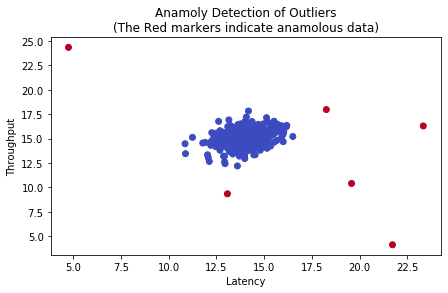

In [13]:
Gtrain_outlier = np.zeros([Gtrain.shape[0],1])
for i in range(len(Gtrain)):
    if Gtrain[i] < eps:
        Gtrain_outlier[i] = 1

X_anamoly = np.append(X, Gtrain_outlier, axis=1)
fig, ax = plt.subplots(1,1,figsize=(7,4))
ax.scatter(X_anamoly[:,0], X_anamoly[:,1], c = X_anamoly[:,2], cmap = 'coolwarm', marker = 'o')
ax.set_title('Anamoly Detection of Outliers\n(The Red markers indicate anamolous data)', size=12)
ax.set_xlabel('Latency')
ax.set_ylabel('Throughput')
plt.show()
        

### Anamoly Detection for Multivariate Data

In [14]:
data2 = loadmat('ex8data2.mat')
X = data2['X']
Xval = data2['Xval']
yval = data2['yval']

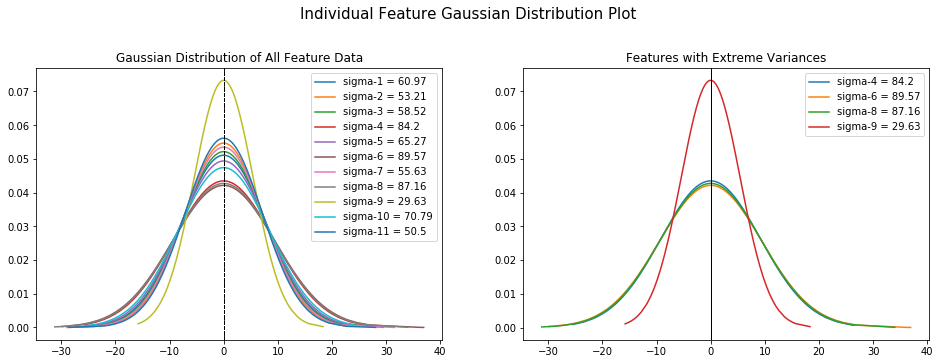

In [15]:
mu, sigma = mu_sigma(X)

fig, ax = plt.subplots(1,2,figsize=(16,5))
colors = ['darkgreen','purple','blue','yellow','orange','black']
labels = list(sigma.diagonal())

X_featsort = []
for i in range(11):
    temp = uni_Gaussian(X[:,i].reshape(-1,1))
    X_featsort.append(temp)

for i in range(11):
    ax[0].plot(X_featsort[i][:,0], X_featsort[i][:,1], label = f'sigma-{i+1} = {round(labels[i],2)}')
    ax[0].legend()
    ax[0].set_title('Gaussian Distribution of All Feature Data')
    ax[0].axvline(0, linestyle='--', color='black', linewidth=1)

low_high = [4,6,8,9]
for i in low_high:
    ax[1].plot(X_featsort[i-1][:,0], X_featsort[i-1][:,1], label = f'sigma-{i} = {round(labels[i-1],2)}')
    ax[1].legend()
    ax[1].set_title('Features with Extreme Variances')
    ax[1].axvline(0, linestyle='-', color='black', linewidth=1)

fig.suptitle('Individual Feature Gaussian Distribution Plot', size=15, y=1.05)
plt.show()


In [16]:
G2train = multiGauss(X-mu, mu, sigma)
G2val, F1, eps = anamoly(Xval, mu, sigma, yval)

print('The optimised value of epsilon = {:.5E}.'.format(eps))
print(f'The F1 score for this epsilon = {round(F1, 4)}.')

count = 0
for i in range(len(G2train)):
    if G2train[i] < eps:
        count += 1
print(f'The number of anamolies found are {count}.')

The optimised value of epsilon = 1.37723E-18.
The F1 score for this epsilon = 0.6154.
The number of anamolies found are 117.


In [17]:
## Scatter Plot

# fig, ax = plt.subplots(1,2,figsize=(16,5), sharey=True)
# colors = ['darkgreen','purple','blue','yellow','orange','black']
# labels = list(sigma.diagonal())
# for i in range(0,6):
#     ax[0].scatter(X[:,i], list(range(X.shape[0])),marker = '.',c = colors[i], label = f'sigma-{i+1} = {round(labels[i],2)}')
#     ax[0].legend(loc=(1,0.6))
#     ax[0].set_xlabel('Feature Spread')
#     ax[0].set_ylabel('Feature Entry')
# for i in range(6,11):
#     ax[1].scatter(X[:,i], list(range(X.shape[0])),marker = '.',c = colors[i-6], label = f'sigma-{i+1} = {round(labels[i],2)}')
#     ax[1].legend(loc=(-0.3,0.1))
#     ax[1].set_xlabel('Feature Spread')

# fig.suptitle('Scatter plot of all features', size=25, x=0.5,y=1.1)
# plt.tight_layout()
# plt.show()